In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)
data_path = "/content/drive/MyDrive/CPSC-8430-Deep-Learning-001/HW1/1.2/"

# Loading MNIST dataset for training
train_data = torchvision.datasets.MNIST(root='./data',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

# Loading MNIST dataset for testing
test_data = torchvision.datasets.MNIST(root='./data',
                                       train=False,
                                       transform=transforms.ToTensor())

# Function to load training data
def get_train_loader(batch_size):
    loader_train = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    return loader_train

# Function to load testing data
def get_test_loader(batch_size):
    loader_test = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=batch_size,
                                              shuffle=False)
    return loader_test

# Display dataset sizes
print("Training set size:", len(train_data), "\nTest set size:", len(test_data))


Training set size: 60000 
Test set size: 10000


In [3]:
class SimpleDNN(nn.Module):
    def __init__(self):
        super(SimpleDNN, self).__init__()
        self.layer1 = nn.Linear(784, 500)
        self.layer2 = nn.Linear(500, 50)
        self.layer3 = nn.Linear(50, 10)

    def forward(self, input_data):
        # flatten the input to a single dimension
        input_data = input_data.view(input_data.size(0), -1)
        input_data = F.relu(self.layer1(input_data))
        input_data = F.relu(self.layer2(input_data))
        output = self.layer3(input_data)
        return output


In [5]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten to one dimension
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training function
def train_model(net, num_epochs, batch_size_train, display_step):
    net.train()
    print('Training started...')
    train_data_loader = get_train_loader(batch_size_train)
    total_steps = len(train_data_loader)
    train_loss_log = []
    epoch_log = []
    accuracy_log = []
    current_epoch = 0
    param_weight_log = pd.DataFrame()
    avg_train_loss_log = []
    avg_train_acc_log = []
    initial_weights = {}

    for epoch in range(num_epochs):
        current_epoch += 1
        correct_predictions = 0
        total_samples = 0
        epoch_loss_sum = 0
        cumulative_accuracy = 0
        epoch_weights = pd.DataFrame()

        for step, (images, labels) in enumerate(train_data_loader):
            images, labels = Variable(images), Variable(labels)
            optimizer.zero_grad()
            
            # Forward pass
            predictions = net(images)
            images.requires_grad = True
            loss = criterion(predictions, labels)
            epoch_loss_sum += loss.item()
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            _, predicted_labels = torch.max(predictions.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()
            accuracy = 100.0 * correct_predictions / total_samples
            cumulative_accuracy += accuracy

            train_loss_log.append(loss.item())
            accuracy_log.append(accuracy)
            epoch_log.append(current_epoch)

            # Print the status at intervals
            if (step + 1) % display_step == 0:
                print(f'Epoch [{current_epoch}/{num_epochs}], Step [{step+1}/{total_steps}], Loss: {loss.item():.4f}', end='\r', flush=True)

        # Collect weights for each epoch
        for param_name, param in net.named_parameters():
            if 'weight' in param_name:
                weight_values = torch.nn.utils.parameters_to_vector(param).detach().numpy()
                epoch_weights = pd.concat([epoch_weights, pd.DataFrame(weight_values).T], axis=1)

        param_weight_log = pd.concat([param_weight_log, epoch_weights], axis=0)

        avg_epoch_loss = epoch_loss_sum / total_steps
        avg_epoch_acc = cumulative_accuracy / total_steps

        avg_train_loss_log.append(avg_epoch_loss)
        avg_train_acc_log.append(avg_epoch_acc)

    return epoch_log, train_loss_log, accuracy_log, avg_train_loss_log, avg_train_acc_log, param_weight_log

# Testing function
def evaluate_model(net, criterion, batch_size_test):
    test_data_loader = get_test_loader(batch_size_test)
    net.eval()
    with torch.no_grad():
        correct_predictions = 0
        total_samples = 0
        cumulative_test_loss = 0
        test_batches = 0
        for images, labels in test_data_loader:
            images, labels = Variable(images), Variable(labels)

            predictions = net(images)
            cumulative_test_loss += criterion(predictions, labels).item()

            # Max returns (value, index)
            _, predicted_labels = torch.max(predictions.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()
            test_batches += 1

    avg_test_loss = cumulative_test_loss / test_batches
    test_accuracy = 100.0 * correct_predictions / total_samples
    print(f'Network Test Accuracy: {test_accuracy}% | Test Loss: {avg_test_loss}', end='\r', flush=True)

    return test_accuracy, avg_test_loss

# Model parameter count
model_params = []
test_net = NeuralNet()
for param in test_net.parameters():
    model_params.append(torch.numel(param))
print(f'Total number of parameters: {np.sum(model_params)}')

# Hyperparameters
num_epochs = 50
full_log = pd.DataFrame()
column_names = ["x", "y", "Epochs"]
training_accuracy_log = {}
testing_accuracy_log = {}
training_loss_log = {}
testing_loss_log = {}
batch_size_train = 1000
batch_size_test = 1000
display_step = 50
criterion = nn.CrossEntropyLoss()
first_layer_weights = pd.DataFrame()

# Running multiple training instances
for trial in range(8):
    model = copy.deepcopy(NeuralNet())
    print(f'Running Trial {trial}')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=1e-4)
    train_epochs, train_losses, train_accs, avg_train_losses, avg_train_accs, model_weights = train_model(model, num_epochs, batch_size_train, display_step)
    
    test_acc, test_loss = evaluate_model(model, criterion, batch_size_test)
    
    full_log = pd.concat([full_log, model_weights], ignore_index=True)
    testing_accuracy_log[trial] = test_acc
    training_loss_log[trial] = avg_train_losses
    testing_loss_log[trial] = test_loss
    training_accuracy_log[trial] = avg_train_accs


Total number of parameters: 418060
Running Trial 0
Training started...
Running Trial 1curacy: 98.0% | Test Loss: 0.06529801525175571
Training started...
Running Trial 2curacy: 98.13% | Test Loss: 0.06025023674592376
Training started...
Running Trial 3curacy: 98.05% | Test Loss: 0.0630902593024075
Training started...
Running Trial 4curacy: 98.07% | Test Loss: 0.06222523981705308
Training started...
Running Trial 5curacy: 98.13% | Test Loss: 0.06156336283311248
Training started...
Running Trial 6curacy: 97.94% | Test Loss: 0.06302910447120666
Training started...
Running Trial 7curacy: 98.15% | Test Loss: 0.060801154281944034
Training started...


In [11]:
trainAccArr = []
for key,values in enumerate(training_accuracy_log):
    trainAccArr.append(training_accuracy_log[key])
trainLossArr = []
for key,values in enumerate(training_loss_log):
    trainLossArr.append(training_loss_log[key])
print(full_log)
train_acc_df = pd.DataFrame(training_accuracy_log)
train_acc_data = np.array(train_acc_df).flatten()

train_loss_df = pd.DataFrame(training_loss_log)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(train_acc_data)}')
t1 = full_log
print(pd.DataFrame(t1))

              0             1             2             3             4    \
0   -1.032108e-02 -1.216428e-02  1.134451e-02  4.880872e-03  3.901150e-03   
1   -1.550036e-03 -2.356548e-03  1.982209e-03  4.929519e-05 -5.293547e-05   
2   -5.594872e-05 -1.800888e-04  1.160116e-04 -6.251767e-06  7.073986e-07   
3    2.899237e-06  6.660505e-07 -2.609453e-06  2.534434e-07 -1.201980e-07   
4   -6.300699e-08  2.327410e-07 -6.156731e-08 -3.542668e-09  1.183466e-08   
..            ...           ...           ...           ...           ...   
395 -7.833515e-39 -1.189207e-38 -8.263289e-39  1.468423e-38 -1.435308e-38   
396 -7.833515e-39 -1.189207e-38 -8.263289e-39  1.468423e-38 -1.435308e-38   
397 -7.833515e-39 -1.189207e-38 -8.263289e-39  1.468423e-38 -1.435308e-38   
398 -7.833515e-39 -1.189207e-38 -8.263289e-39  1.468423e-38 -1.435308e-38   
399 -7.833515e-39 -1.189207e-38 -8.263289e-39  1.468423e-38 -1.435308e-38   

              5             6             7             8             9    

In [12]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    pcaVal = pcaOperation.fit_transform(paramDF)

    itrData = np.full((pcaVal.shape[0],1),itr)

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf

In [15]:
t1 = np.array(t1)
pca = PCA(n_components=2)
new_data = pca.fit_transform(t1)
# scaling=StandardScaler()
# scaled_data = scaling.fit_transform(new_data)

allEpochDf = pd.DataFrame(new_data,columns=['x','y'])

eps_each_time = [i for i in range(num_epochs)] * 8
times = np.repeat([i for i in range(8)],num_epochs)

allEpochDf['Epoch']=eps_each_time
allEpochDf['Iteration']=(times)
allEpochDf["Acc"] = train_acc_data
allEpochDf["Loss"] = train_loss_data

print(allEpochDf)
epoch3Df = allEpochDf.loc[(allEpochDf['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
print(epoch3Df)


            x         y  Epoch  Iteration        Acc      Loss
0    1.936150  1.241151      0          0  53.851070  1.287742
1    2.376735  1.525113      1          0  50.242016  1.326942
2    2.660831  1.702627      2          0  55.401207  1.218247
3    2.911830  1.858324      3          0  53.750603  1.268923
4    3.138322  2.003947      4          0  49.594897  1.297249
..        ...       ...    ...        ...        ...       ...
395 -5.327017 -6.654919     45          7  99.876557  0.013488
396 -5.312455 -6.638740     46          7  99.859034  0.013735
397 -5.295768 -6.616747     47          7  99.851603  0.013140
398 -5.279070 -6.600136     48          7  99.917913  0.011854
399 -5.264820 -6.583764     49          7  99.859969  0.013097

[400 rows x 6 columns]
            x         y  Epoch  Iteration        Acc      Loss
0    2.660831  1.702627      2          0  55.401207  1.218247
1    3.332292  2.127375      5          0  58.240362  1.256800
2    3.757178  2.394021      8 

In [16]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)
     

128

<Figure size 5000x2500 with 0 Axes>

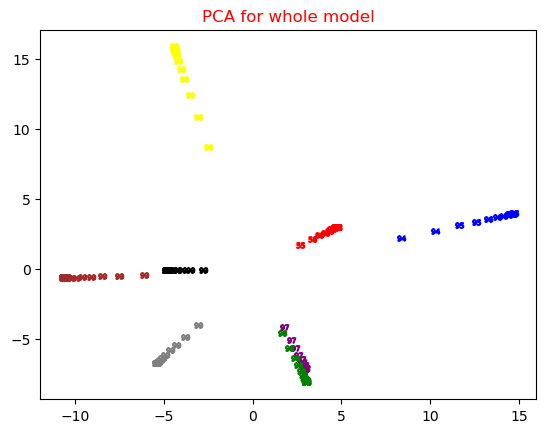

<Figure size 5000x2500 with 0 Axes>

In [20]:
cmap = ['red','blue','purple','green','yellow','brown','black','grey']

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for whole model",color="r")
    
plt.figure(figsize=[10,5],dpi=500)


            x         y  Epoch  Iteration        Acc      Loss
0   -0.286751  0.163149      0          0  53.851070  1.287742
1   -0.332121  0.209022      1          0  50.242016  1.326942
2   -0.368710  0.231007      2          0  55.401207  1.218247
3   -0.395022  0.246852      3          0  53.750603  1.268923
4   -0.419635  0.256983      4          0  49.594897  1.297249
..        ...       ...    ...        ...        ...       ...
395  2.546572 -0.993828     45          7  99.876557  0.013488
396  2.536555 -0.988493     46          7  99.859034  0.013735
397  2.525722 -0.983458     47          7  99.851603  0.013140
398  2.513587 -0.980630     48          7  99.917913  0.011854
399  2.504028 -0.976053     49          7  99.859969  0.013097

[400 rows x 6 columns]


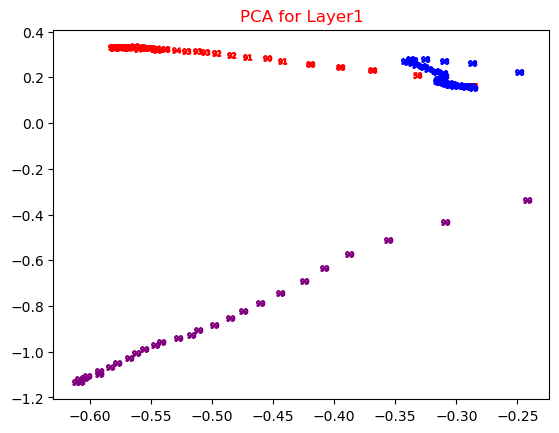

In [25]:
layer1_Df = full_log.iloc[:,0:7840]
t2 = layer1_Df 
t2 = np.array(t2)
pca = PCA(n_components=2)
new_data2 = pca.fit_transform(t2)
layer1Df = pd.DataFrame(new_data2,columns=['x','y'])

eps_each_time = [i for i in range(num_epochs)] * 8
times = np.repeat([i for i in range(8)],num_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = train_acc_data
layer1Df["Loss"] = train_loss_data
print(layer1Df)
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="r")
plt.show()